In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from matplotlib import animation, rc
from IPython.display import HTML
#PRINTING THE DISLOCATION POSITIONS
def print_dis():
    print(x_dis, y_dis)
    

#CAUTION, SOME FORMULAE GIVEN IN THE THESIS NEED TO BE RECHECKED - STRESS FIELD AND THE VELOCITY PROFILE
#GRID GENERATION

#Grid size in terms of Burger's vector, Burger's vector = 1unit in the x-direction
#The grid is a sqaure
grid_size = 50

#Finding out the grid coordinates
x_coord = np.linspace(0, grid_size - 1, grid_size)
y_coord = x_coord
#print(y_coord)

#GENERATING THE DISLOCATIONS

#Number of disclocations = num_dis
num_dis = 10

#Dislocations identity = (x, y ,s); where s can be +1 or -1 DEFINED GLOBALLY. THE COORDINATES OF THE DISLOCATIONS ARE UPDATED 
#GLOBALLY
s = [1, -1]
x_dis = np.random.choice(x_coord, num_dis)
y_dis = np.random.choice(y_coord, num_dis)
s_dis = np.random.choice(s, num_dis)
print_dis()

#PLOTTING FUNCTION
def plot_dis():
    #Plotting the dislocations
    plt.axis([0, grid_size - 1, 0, grid_size - 1])
    plt.xlabel('x(b)')
    plt.ylabel('y(b)')
    plt.title('Dislocations In The Box')
    plt.grid(True)

    for i in range(len(s_dis)):
        if s_dis[i] == 1:
            plt.plot(x_dis[i], y_dis[i], 'r^')
        
        else:
            plt.plot(x_dis[i], y_dis[i], 'bv')
    plt.show()



#ANNIHILATION FUNCTION
#The dislocations will be annihilated if the distance between them is strictly less than the length of the burger's vector

def annihilate(b):
    e = []
    global x_dis
    global y_dis
    global s_dis
    a = len(x_dis)
    for i in range(a):
        for j in range(i+1, a):
            dis = ((x_dis[i] - x_dis[j]) ** 2 + (y_dis[i] - y_dis[j]) ** 2) ** 0.5
            if dis < b:
                e.append(j)
                e.append(i)
                
    e = set(e)
    e = sorted(e, reverse = True)
    
    for i in e:
        x_dis = np.delete(x_dis, i)
        y_dis = np.delete(y_dis, i)
        s_dis = np.delete(s_dis, i)
        
    return               

[14.  6. 17. 11.  5. 48. 46. 14. 36. 22.] [ 0. 22. 17.  4. 14.  9. 47. 21. 17. 11.]


In [2]:
#STRESS FIELD AT A PARTICULAR POINT


#The function evaluates the stress field at a point in the box. It takes the position of the dislocation(xd, yd) whose stress at a 
#point(x, y) has to be calculated. Burger's vector is kept as 1. Stress is measured in terms of meu/(2*pi*(1-v)). 
#Time is measured in terms of 2*pi*(1-neu)/(meu * mobi * burgers)
def stress_field(x_d, y_d, x, y):
    stress = np.pi/grid_size * np.sin(2 * np.pi * (x - x_d)/grid_size) * (np.cosh(2 * np.pi * (y - y_d)/grid_size) - np.cos(2 * np.pi * (x - x_d)/grid_size) - 
                                                           (2 * np.pi * (y - y_d)/grid_size) * np.sinh(2 * np.pi * (y - y_d)/grid_size))/((np.cosh(2 * np.pi * (y - y_d)/grid_size) - np.cos(2 * np.pi * (x - x_d)/grid_size)) ** 2)
    
    return stress
    
#CALCULATING THE 

In [3]:
#CALCULATING THE VELOCITY OF EACH DISLOCATION

#No climbing, just gliding =====> y is constant

#The following function calculates the (total sum stress + sigma_ext) * s * b^2 at dislocation(x, y), z = s_dis(x,y)
def sum_stress(x, y, s, x_dummy, stress_external):
    sum_inter = 0 
    for i in range(len(x_dummy)):
        if x == x_dummy[i] and y == y_dis[i]:
            continue
        else:
            sum_inter = sum_inter + stress_field(x_dummy[i], y_dis[i], x, y) * s_dis[i]
    sum_inter = sum_inter + stress_external
    #Burgers vector value is 1
    return(s * sum_inter)

#NEW LOCATION OF THE DISLOCATION

#Units of timestep are 2 * pi * (1 - neu)/(meu * mobi * Burger). Timestep thus I am taking is 1000

def new_location(step, stress_ext):
    x_int = np.copy(x_dis)
    x_dummy = np.copy(x_dis)
    itr = len(x_dummy)
    
    k1 = np.zeros(itr)
    k2 = np.zeros(itr)
    k3 = np.zeros(itr)
    k4 = np.zeros(itr)
    
    for i in range(itr):
        k1[i] = sum_stress(x_dummy[i], y_dis[i], s_dis[i], x_dummy, stress_ext)
                   
    for i in range(itr):
        x_dummy[i] = x_dis[i] + step/2.0 * k1[i]
        #print(x_dis[i],x_dis[i] + step/2.0 * a[i],x_dummy[i],'{:.16f}'.format(x_dummy[i] - x_dis[i]))
    
    
    for i in range(itr):
        k2[i] = sum_stress(x_dummy[i], y_dis[i], s_dis[i], x_dummy, stress_ext)
        
    for i in range(itr):
        x_dummy[i] = x_dis[i] + step/2 * k2[i]
    
    
    for i in range(itr):
        k3[i] = sum_stress(x_dummy[i], y_dis[i], s_dis[i], x_dummy, stress_ext)
        
    for i in range(itr):
        x_dummy[i] = x_dis[i] + step * k3[i]
        
    
    for i in range(itr):
        k4[i] = sum_stress(x_dummy[i], y_dis[i], s_dis[i], x_dummy, stress_ext)
    
    for i in range(itr):
        x_dis[i] = (x_dis[i] + step/6 * (k1[i] + 2 * k2[i] + 2 * k3[i] + k4[i]))%grid_size
       
    return x_int
     

#LOCATION AFTER "t" TIMESTEPS
def location_after_iterations(itr, step, stress):
    strain = np.zeros(itr)
    
    for j in range(itr):
        dummy = new_location(step, stress)
        annihilate(1)
        g = len(s_dis)
        for k in range(g):
            strain[j] = (strain[j] + s_dis[k] * (x_dis[k] - dummy[k]))
        strain[j] = strain[j]/(grid_size ** 2)
        
    for i in range(itr):
        if i != 0:
            strain[i] = strain[i] + strain[i - 1] 
            
    return strain


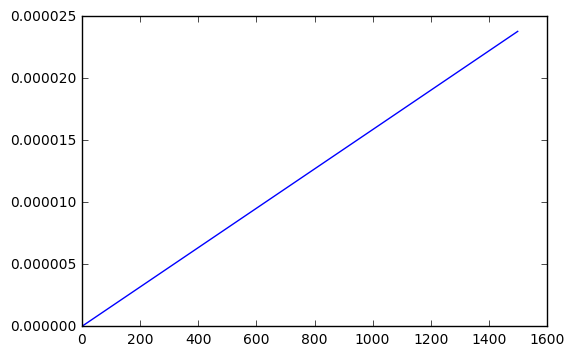

"\nfig,ax = plt.subplots()\nax.set_xlim(( 0, grid_size))\nax.set_ylim((0, grid_size))\n\nline1, = ax.plot([], [], 'bo')\nline2, = ax.plot([], [], 'ro')\n\n# initialization function: plot the background of each frame\ndef init():\n    line1.set_data([], [])\n    line2.set_data([], [])\n    return line1, line2\n\n# animation function.  This is called sequentially\ndef animate(i):\n    location_after_iterations(1, 1, 1)\n    x_pos = [[], []]\n    y_pos = [[], []]\n    for i in range(len(x_dis)):\n        if(s_dis[i] == 1):\n            x_pos[0].append(x_dis[i])        \n            y_pos[0].append(y_dis[i])\n        else:\n            x_pos[1].append(x_dis[i])        \n            y_pos[1].append(y_dis[i])\n        \n        line1.set_data(x_pos[0], y_pos[0])\n        line2.set_data(x_pos[1], y_pos[1])\n    return line1, line2\n\n# call the animator.  blit=True means only re-draw the parts that have changed.\nanim = animation.FuncAnimation(fig, animate,init_func = init, frames=200, blit=T

In [4]:
strain = location_after_iterations(1500, 0.0001, 0)
plt.plot(strain)
plt.show()
"""
fig,ax = plt.subplots()
ax.set_xlim(( 0, grid_size))
ax.set_ylim((0, grid_size))

line1, = ax.plot([], [], 'bo')
line2, = ax.plot([], [], 'ro')

# initialization function: plot the background of each frame
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return line1, line2

# animation function.  This is called sequentially
def animate(i):
    location_after_iterations(1, 1, 1)
    x_pos = [[], []]
    y_pos = [[], []]
    for i in range(len(x_dis)):
        if(s_dis[i] == 1):
            x_pos[0].append(x_dis[i])        
            y_pos[0].append(y_dis[i])
        else:
            x_pos[1].append(x_dis[i])        
            y_pos[1].append(y_dis[i])
        
        line1.set_data(x_pos[0], y_pos[0])
        line2.set_data(x_pos[1], y_pos[1])
    return line1, line2

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate,init_func = init, frames=200, blit=True)
HTML(anim.to_html5_video())
"""

###### print_dis()
plot_dis()

C:\Users\Micky\Anaconda3\lib\site-packages\numpy\ma\core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
C:\Users\Micky\Anaconda3\lib\site-packages\numpy\ma\core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


[[-0.08216109 -0.08508108 -0.08792023 ...  0.06706342  0.06426964
   0.06159947]
 [-0.08445762 -0.08746359 -0.09038484 ...  0.06738052  0.06454837
   0.06184465]
 [-0.08670617 -0.08979538 -0.09279548 ...  0.06752476  0.06466195
   0.06193223]
 ...
 [-0.08601794 -0.08725719 -0.08835019 ...  0.02538915  0.02556293
   0.02576182]
 [-0.07905693 -0.0798967  -0.08057178 ...  0.02327579  0.02354442
   0.02383657]
 [-0.0721784  -0.07264808 -0.07293923 ...  0.02117442  0.02153307
   0.02191365]]


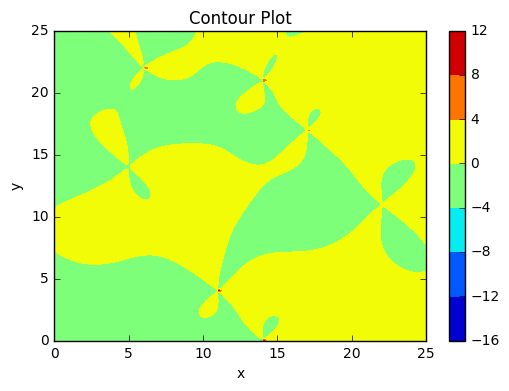

In [5]:
#Contour plot
number = 150
xlist = np.linspace(0, grid_size/2, number)
ylist = np.linspace(0, grid_size/2, number)
X, Y = np.meshgrid(xlist, ylist)
Z = (0 * X )
for i in range(number):
    for j in range(number):
        for k in range(len(s_dis)):
            Z[i][j] = Z[i][j] + stress_field(x_dis[k], y_dis[k], X[i][j], Y[i][j])

plt.figure()
cp = plt.contourf(X, Y, Z)
plt.colorbar(cp)
#plt.clabel(cp, inline=True, fontsize=10)
print(Z)
plt.title('Contour Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.show()